# ViT + BERT

## Import Library

In [4]:
# pip install pycocoevalcap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 11.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 24.9 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [5]:
# Import libraries

import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from transformers import AutoImageProcessor, AutoTokenizer, VisionEncoderDecoderModel
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.bleu.bleu import Bleu
import os
import zipfile

## Data Preparation

In [6]:
# Dataset Class

class ImageCaptionDataset(Dataset):
    def __init__(self, text_df, tokenizer, image_height, image_width):
        self.text_df = text_df
        self.tokenizer = tokenizer
        self.image_height = image_height
        self.image_width = image_width
        
    def __len__(self):
        return len(self.text_df)
    
    def __getitem__(self, index):
        image_filename = self.text_df.iloc[index]['image']
        
        # Load image
        image = Image.open(image_filename).convert("RGB")  # Convert all images to RGB
        
        # Resize and convert to numpy array
        image = np.array(image.resize((self.image_width, self.image_height)), dtype=np.uint8)
        image = torch.tensor(np.moveaxis(image, -1, 0))  # Convert HWC to CHW (PyTorch format)
        
        # Tokenize caption
        caption_token = self.tokenizer(
            self.text_df.iloc[index]['caption'], 
            add_special_tokens=True, 
            padding="max_length", 
            max_length=32, 
            truncation=True
        ).input_ids 
        caption_token = [token if token != self.tokenizer.pad_token_id else -100 for token in caption_token]
        
        return {"pixel_values": image, "caption_token": torch.tensor(caption_token)}


In [7]:
# path to images

coco_train_images = "/kaggle/input/coco-2017-dataset/coco2017/train2017/"
coco_val_images = "/kaggle/input/coco-2017-dataset/coco2017/val2017/"

In [8]:
# Load image and caption Dataframe

train_df = pd.read_csv("/kaggle/input/coco-df/df_coco_train.csv", index_col=False)
# train_df.drop('Unnamed: 0', axis=1, inplace=True)

val_df = pd.read_csv("/kaggle/input/coco-df/df_coco_val.csv", index_col=False)
val_df.drop('Unnamed: 0', axis=1, inplace=True)

In [9]:
train_df.head()

,image,caption
0,/kaggle/input/coco-2017-dataset/coco2017/train...,Many yaks are grazing in a field of grass.
1,/kaggle/input/coco-2017-dataset/coco2017/train...,A baseball player about to hit a baseball.
2,/kaggle/input/coco-2017-dataset/coco2017/train...,A baseball player is standing g at the basebLl...
3,/kaggle/input/coco-2017-dataset/coco2017/train...,A man in plaid shirt flying a kit in city space.
4,/kaggle/input/coco-2017-dataset/coco2017/train...,there's a lot of food in that oven


## Vision Encoder Decoder Models

In [10]:
# # Setting up model

# from PIL import Image
# import requests

# image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
# decoder_tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# if decoder_tokenizer.pad_token is None:
#     decoder_tokenizer.pad_token = '[PAD]'

# model = VisionEncoderDecoderModel.from_encoder_decoder_pretrained("google/vit-base-patch16-224-in21k", "bert-base-uncased")

# model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
# model.config.pad_token_id = decoder_tokenizer.pad_token_id
# model.config.vocab_size = model.config.decoder.vocab_size

In [11]:
# Load trained model

model_path = "/kaggle/input/vit-bert-pretrained/vit_bert_third (1)/vit_bert_model"

# File paths inside the model directory
config_file = f"{model_path}/config.json"
special_tokens_map = f"{model_path}/special_tokens_map.json"
tokenizer_file = f"{model_path}/tokenizer.json"
vocab_file = f"{model_path}/vocab.txt"
model_weights = f"{model_path}/pytorch_model.bin"


In [12]:
# Load the trained model
model = VisionEncoderDecoderModel.from_pretrained(model_path)

# Load the tokenizer for the decoder (BERT tokenizer)
decoder_tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load the image processor for the encoder
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

# Ensure pad token is set
if decoder_tokenizer.pad_token is None:
    decoder_tokenizer.pad_token = '[PAD]'

# Update model config
model.config.decoder_start_token_id = decoder_tokenizer.cls_token_id
model.config.pad_token_id = decoder_tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size

print("Model, tokenizer, and image processor loaded successfully!")

Model, tokenizer, and image processor loaded successfully!


In [13]:
# Create datasets and dataloaders

train_dataset = ImageCaptionDataset(text_df=train_df, tokenizer=decoder_tokenizer, image_height=224, image_width=224)
val_dataset = ImageCaptionDataset(text_df=val_df, tokenizer=decoder_tokenizer, image_height=224, image_width=224)

In [14]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=32)
val_dataloader = DataLoader(val_dataset, batch_size=32)

In [15]:
len(train_dataloader)

9375

## Training Setup

In [16]:
# Set up training

from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

from transformers import get_scheduler
epochs = 10
num_training_steps = epochs * len(train_dataloader)
lr_scheduler = get_scheduler( name="linear", optimizer=optimizer, num_warmup_steps=int(num_training_steps/5), num_training_steps=num_training_steps )


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    
print(device)

model.to(device)

cuda


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [17]:
# zip file
def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file), 
                       os.path.relpath(os.path.join(root, file), 
                                       os.path.join(path, '..')))

In [18]:
# Train loop

model.train()
for epoch in range(epochs):
    epoch_losses = []  # Track losses for the current epoch

    print(f"Starting Epoch {epoch+1}/{epochs}")
    
    for batch_idx, batch in enumerate(train_dataloader, start=1):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(pixel_values=batch['pixel_values'], labels=batch['caption_token'])
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        # Track batch loss
        epoch_losses.append(loss.item())

        if batch_idx % 1000 == 0:
            print(f"Epoch {epoch+1}, Batch {batch_idx}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    
    # Calculate and print the average loss for the epoch
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    print(f"Epoch {epoch+1}/{epochs}, Average Loss: {avg_epoch_loss:.4f}")

    # Save the model at the end of the epoch
    save_directory = "vit_bert_model"
    model.save_pretrained(save_directory)
    decoder_tokenizer.save_pretrained(save_directory)
    print(f"Model saved to {save_directory}")

    with zipfile.ZipFile('vit_bert_fourth.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipdir('/kaggle/working/vit_bert_model', zipf)
    
    print("Model folder has been zipped to vit_bert_third.zip.")


Starting Epoch 1/10
Epoch 1, Batch 1000/9375, Loss: 1.9120
Epoch 1, Batch 2000/9375, Loss: 1.4436
Epoch 1, Batch 3000/9375, Loss: 1.6085
Epoch 1, Batch 4000/9375, Loss: 1.7922
Epoch 1, Batch 5000/9375, Loss: 1.8354
Epoch 1, Batch 6000/9375, Loss: 1.7631
Epoch 1, Batch 7000/9375, Loss: 1.5260
Epoch 1, Batch 8000/9375, Loss: 1.7009


KeyboardInterrupt: 

In [19]:
# Save the model at the end of the epoch
save_directory = "vit_bert_model"
model.save_pretrained(save_directory)
decoder_tokenizer.save_pretrained(save_directory)
print(f"Model saved to {save_directory}")

Model saved to vit_bert_model


In [20]:
# zip file
with zipfile.ZipFile('vit_bert_fourth.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    zipdir('/kaggle/working/vit_bert_model', zipf)

In [21]:
from IPython.display import FileLink
FileLink('vit_bert_fourth.zip')

/kaggle/working/vit_bert_fourth.zip

## Evaluating Model

In [28]:
def generate_captions(model, dataloader, tokenizer, device):
    model.eval()
    predictions = []
    references = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Captions"):
            # Move batch to device
            pixel_values = batch['pixel_values'].to(device)
            captions = batch['caption_token']

            # Generate predictions
            generated_ids = model.generate(pixel_values=pixel_values, max_length=32)
            generated_texts = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

            # Store references and predictions
            for idx, text in enumerate(generated_texts):
                predictions.append(text)

                # Filter out -100 from the reference tokens before decoding
                valid_tokens = [token for token in captions[idx].cpu().numpy() if token != -100]
                references.append([tokenizer.decode(valid_tokens, skip_special_tokens=True)])

    return predictions, references


In [ ]:
# Define the function to compute evaluation metrics
def evaluate(predictions, references):
    """
    Evaluate the generated captions using BLEU, CIDEr, and METEOR.
    """
    print("\nStarting Evaluation...")

    # Prepare predictions and references in COCO format
    # The format requires:
    #   predictions = {image_id: "generated caption"}
    #   references = {image_id: ["reference caption 1", "reference caption 2", ...]}
    assert len(predictions) == len(references), "Predictions and References length mismatch!"

    formatted_predictions = {idx: [pred] for idx, pred in enumerate(predictions)}
    formatted_references = {idx: refs for idx, refs in enumerate(references)}

    # Initialize the evaluators
    cider_scorer = Cider()
    meteor_scorer = Meteor()
    bleu_scorer = Bleu(4)  # BLEU up to 4-grams

    # Compute CIDEr
    cider_score, _ = cider_scorer.compute_score(formatted_references, formatted_predictions)
    print(f"CIDEr Score: {cider_score:.4f}")

    # Compute METEOR
    meteor_score, _ = meteor_scorer.compute_score(formatted_references, formatted_predictions)
    print(f"METEOR Score: {meteor_score:.4f}")

    # Compute BLEU
    bleu_score, _ = bleu_scorer.compute_score(formatted_references, formatted_predictions)
    print(f"BLEU-1 Score: {bleu_score[0]:.4f}")
    print(f"BLEU-2 Score: {bleu_score[1]:.4f}")
    print(f"BLEU-3 Score: {bleu_score[2]:.4f}")
    print(f"BLEU-4 Score: {bleu_score[3]:.4f}")

    return {"CIDEr": cider_score, "METEOR": meteor_score, "BLEU": bleu_score}

In [ ]:
# Generate captions and evaluate
predictions, references = generate_captions(model, val_dataloader, decoder_tokenizer, device)
evaluation_results = evaluate(predictions, references)

# Print final results
print("\nEvaluation Complete!")
print("Final Results:", evaluation_results)

In [ ]:
model.eval()
losses = []
i = 0

all_predictions = []
all_references = []

for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(pixel_values=batch['pixel_values'], labels=batch['caption_token'])

    logits = outputs.logits
    loss = outputs.loss
    losses.append(loss)

    predictions = torch.argmax(logits, dim=-1)
    predictions = decoder_tokenizer.batch_decode(predictions, skip_special_tokens=True)
    predictions = [pred_sen.replace(".", "").split() for pred_sen in predictions]  # Tokenize

    references = [
        [decoder_tokenizer.decode([0 if token == -100 else token for token in ref]).split()]
        for ref in batch['caption_token'].tolist()
    ]  

    all_predictions.extend(predictions)
    all_references.extend(references)

smooth = SmoothingFunction().method4
bleu_score = corpus_bleu(all_references, all_predictions, smoothing_function=smooth)

print("Val Loss:", torch.sum(torch.tensor(losses)))
print("BLEU Score on Val Set:", bleu_score)


## Saving Model

In [ ]:
# Save the model and tokenizer

# save_directory = "vit_bert_model"
# model.save_pretrained(save_directory)
# decoder_tokenizer.save_pretrained(save_directory)

# print(f"Model and tokenizer saved to {save_directory}")

## Generating Captions

In [29]:
def generate_caption(image, model, tokenizer, device):
    image = torch.unsqueeze(torch.tensor(image), 0).to(device)
    
    encoder_output = model.encoder(pixel_values=image)
    
    decoder_input_ids = torch.tensor(tokenizer.encode("[CLS]")).unsqueeze(0).to(device)

    generated_ids = []
    
    max_length = 32
    
    for _ in range(max_length):
        outputs = model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_output.last_hidden_state)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        
        generated_ids.append(next_token_id.item())
        
        if next_token_id.item() == tokenizer.sep_token_id:
            break
        
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)
    
    generated_caption = tokenizer.decode(generated_ids, skip_special_tokens=True)
    
    image = np.moveaxis(image[0].cpu().numpy(), 0, -1)
    plt.figure(figsize=(4, 4))
    plt.imshow(image)
    plt.axis('off')
    plt.show()
    print("Generated Caption:", generated_caption)
    
    return generated_caption

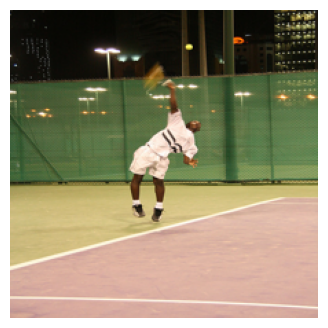

Generated Caption: a man playing tennis on a tennis court.


In [30]:
# generate sample caption for train dataset
pred_caption = generate_caption(
    image=train_dataset.__getitem__(50)['pixel_values'].numpy(),
    model=model,
    tokenizer=decoder_tokenizer,
    device=device
)

In [ ]:
# generate sample of train dataset
for index in np.random.randint(int(train_df.shape[0]/4 - 1),size=20):
    pred_caption = generate_caption( image=train_dataset.__getitem__(index)['pixel_values'].numpy(), model=model , tokenizer=decoder_tokenizer ,
    device=device )

***

## Generate Caption for New Image

In [31]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

def generate_caption_with_image(image, model, tokenizer, device, max_length=32):
    """
    Generate a caption for a single image.
    Args:
        image: Image tensor (C, H, W) or preprocessed numpy array.
        model: Trained VisionEncoderDecoderModel.
        tokenizer: Tokenizer for decoding captions.
        device: Device to run the model on.
        max_length: Maximum length of the generated caption.
    """
    # Preprocess and move image to the device
    image_tensor = torch.unsqueeze(torch.tensor(image), 0).to(device)

    # Pass through encoder
    encoder_output = model.encoder(pixel_values=image_tensor)
    decoder_input_ids = torch.tensor(tokenizer.encode("[CLS]")).unsqueeze(0).to(device)

    generated_ids = []

    # Auto-regressive generation
    for _ in range(max_length):
        outputs = model.decoder(input_ids=decoder_input_ids, encoder_hidden_states=encoder_output.last_hidden_state)
        next_token_logits = outputs.logits[:, -1, :]
        next_token_id = next_token_logits.argmax(1).unsqueeze(-1)
        
        generated_ids.append(next_token_id.item())
        
        if next_token_id.item() == tokenizer.sep_token_id:  # Stop if [SEP] token is generated
            break
        
        decoder_input_ids = torch.cat([decoder_input_ids, next_token_id], dim=-1)

    # Decode the generated IDs
    generated_caption = tokenizer.decode(generated_ids, skip_special_tokens=True)

    # Display the image
    image_to_show = np.moveaxis(image, 0, -1)  # Convert from (C, H, W) to (H, W, C)
    plt.figure(figsize=(5, 5))
    plt.imshow(image_to_show)
    plt.axis('off')
    plt.title(f"{generated_caption}", fontsize=10, color='black')
    plt.show()

    # print("Generated Caption:", generated_caption)
    return generated_caption


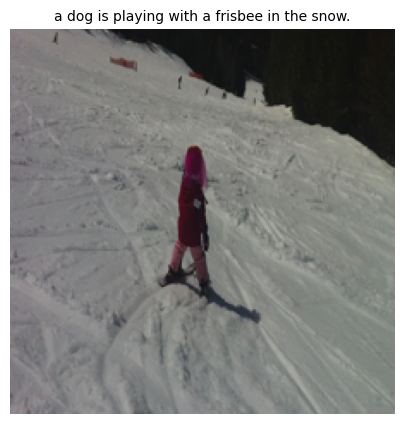

In [32]:
# Path to the new image
new_image_path = "/kaggle/input/coco-2017-dataset/coco2017/test2017/000000000408.jpg"

# Load and preprocess the image
new_image = Image.open(new_image_path).convert("RGB")
new_image = np.array(new_image.resize((224, 224))).transpose((2, 0, 1))  # Convert to (C, H, W)

# Generate a caption for the new image
generated_caption = generate_caption_with_image(new_image, model, decoder_tokenizer, device)

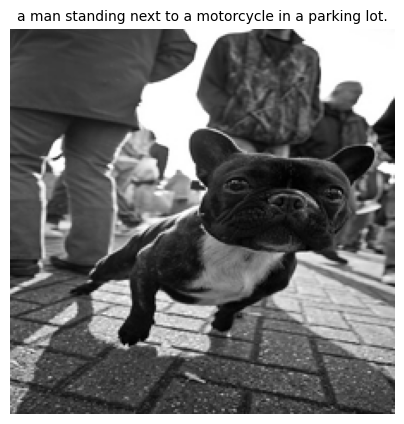

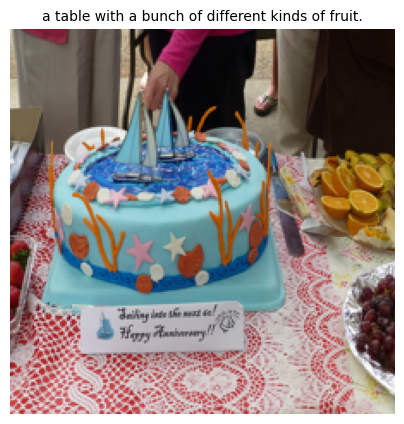

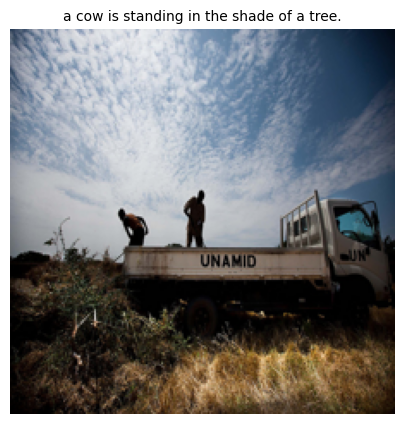

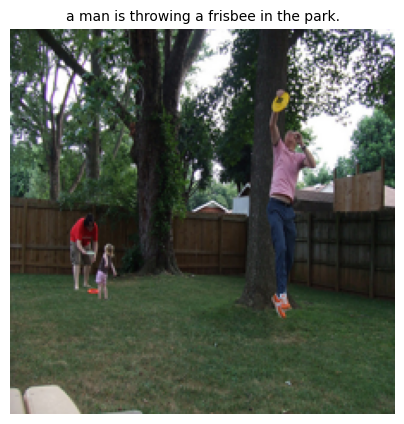

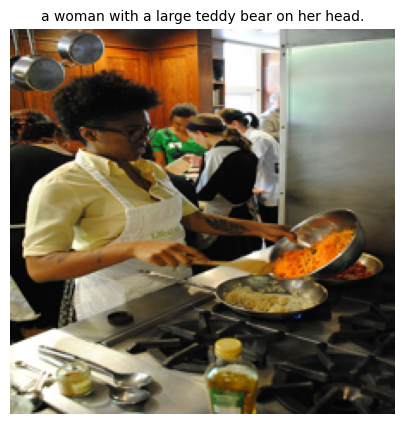

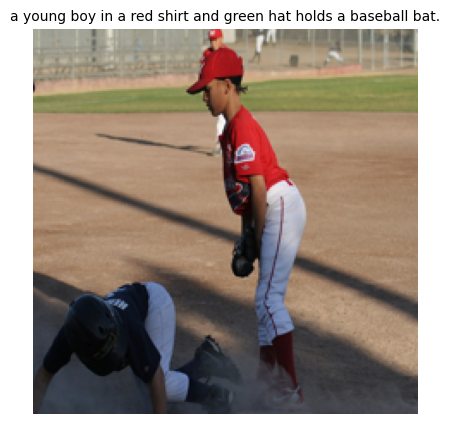

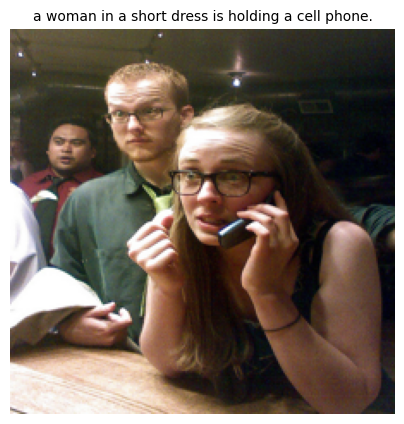

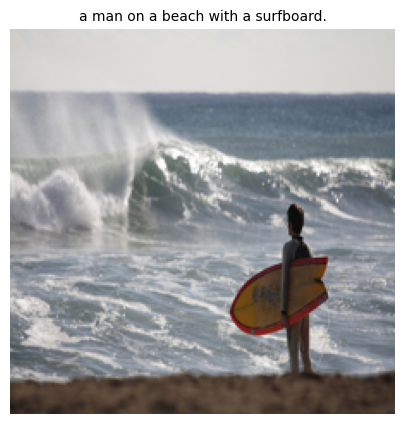

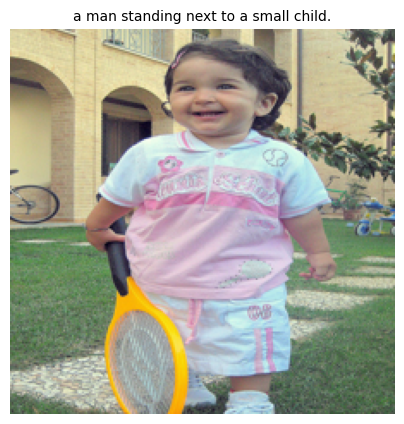

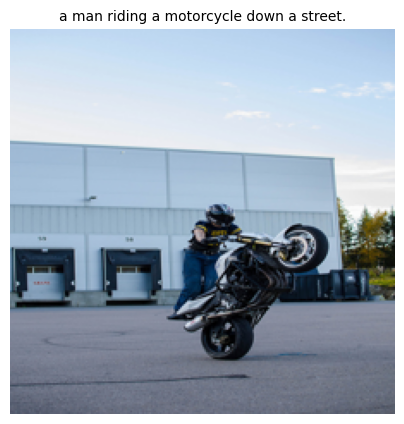

In [33]:
# Loop to generate several random test image

import os
import random
from PIL import Image
import numpy as np

# Path to the image folder
image_folder = "/kaggle/input/coco-2017-dataset/coco2017/test2017"

# Loop through the folder to process random images with a limit
def generate_captions_from_folder(folder_path, model, decoder_tokenizer, device, limit=10):
    # List all files in the folder
    image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Select a random subset of files
    random_files = random.sample(image_files, min(limit, len(image_files)))
    
    # Iterate through the random subset
    for image_file in random_files:
        image_path = os.path.join(folder_path, image_file)
        
        # Load and preprocess the image
        image = Image.open(image_path).convert("RGB")
        image = np.array(image.resize((224, 224))).transpose((2, 0, 1))  # Convert to (C, H, W)
        
        # Generate a caption
        generated_caption = generate_caption_with_image(image, model, decoder_tokenizer, device)

# Example function call
generate_captions_from_folder(image_folder, model, decoder_tokenizer, device, limit=10)


In [ ]:
def generate_captions_for_validation(model, dataloader, tokenizer, device, num_images=5, max_length=32):
    """
    Generate captions for images in the validation dataset and display the first 'num_images' with their captions.
    Args:
        model: Trained VisionEncoderDecoderModel.
        dataloader: DataLoader for validation dataset.
        tokenizer: Tokenizer for decoding captions.
        device: Device to run the model on.
        num_images: Number of images to display.
        max_length: Maximum length of the generated caption.
    """
    model.eval()
    images_shown = 0

    with torch.no_grad():
        for batch in dataloader:
            # Move images to the device
            pixel_values = batch['pixel_values'].to(device)
            
            # Process images one by one to display and caption
            for i in range(len(pixel_values)):
                if images_shown >= num_images:
                    return
                
                image = pixel_values[i].cpu().numpy()
                caption = generate_caption(image, model, tokenizer, device, max_length=max_length)
                images_shown += 1


In [ ]:
# Generate and display captions for the first 5 images in the validation dataset
generate_captions_for_validation(model, val_dataloader, decoder_tokenizer, device, num_images=5)


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
from pycocoevalcap.cider.cider import Cider
from pycocoevalcap.meteor.meteor import Meteor
from pycocoevalcap.bleu.bleu import Bleu

def generate_captions_for_validation_with_eval(model, dataloader, tokenizer, device, max_length=32):
    """
    Generate captions for all images in the validation dataset and compute evaluation metrics (CIDEr, METEOR, BLEU).
    Args:
        model: Trained VisionEncoderDecoderModel.
        dataloader: DataLoader for validation dataset.
        tokenizer: Tokenizer for decoding captions.
        device: Device to run the model on.
        max_length: Maximum length of the generated caption.
    """
    model.eval()
    predictions = []
    references = []

    print("Generating captions for validation data...")

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Generating Captions"):
            pixel_values = batch['pixel_values'].to(device)
            batch_captions = batch['caption_token']

            for i in range(len(pixel_values)):
                # Generate caption using the provided generation code
                image = pixel_values[i].cpu().numpy()
                generated_caption = generate_caption(image, model, tokenizer, device, max_length=max_length)

                # Store the generated caption
                predictions.append(generated_caption)

                # Decode reference captions (ground-truth captions)
                valid_tokens = [token for token in batch_captions[i].cpu().numpy() if token != -100]
                reference_caption = tokenizer.decode(valid_tokens, skip_special_tokens=True)
                references.append([reference_caption])  # Wrap in a list for evaluation

    print("Caption generation complete. Now evaluating...")

    # Format predictions and references for COCO evaluation
    formatted_predictions = {idx: [pred] for idx, pred in enumerate(predictions)}
    formatted_references = {idx: refs for idx, refs in enumerate(references)}

    # Initialize evaluators
    cider_scorer = Cider()
    meteor_scorer = Meteor()
    bleu_scorer = Bleu(4)  # Up to 4-grams

    # Compute CIDEr
    cider_score, _ = cider_scorer.compute_score(formatted_references, formatted_predictions)
    print(f"CIDEr Score: {cider_score:.4f}")

    # Compute METEOR
    meteor_score, _ = meteor_scorer.compute_score(formatted_references, formatted_predictions)
    print(f"METEOR Score: {meteor_score:.4f}")

    # Compute BLEU
    bleu_score, _ = bleu_scorer.compute_score(formatted_references, formatted_predictions)
    print(f"BLEU-1 Score: {bleu_score[0]:.4f}")
    print(f"BLEU-2 Score: {bleu_score[1]:.4f}")
    print(f"BLEU-3 Score: {bleu_score[2]:.4f}")
    print(f"BLEU-4 Score: {bleu_score[3]:.4f}")

    return {
        "CIDEr": cider_score,
        "METEOR": meteor_score,
        "BLEU": bleu_score
    }


In [ ]:
# Generate captions and evaluate on the validation dataset
evaluation_results = generate_captions_for_validation_with_eval(model, val_dataloader, decoder_tokenizer, device)

# Print the evaluation results
print("\nEvaluation Results:")
for metric, score in evaluation_results.items():
    print(f"{metric}: {score}")